In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Concatenate
from keras import regularizers
from keras.callbacks import History, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

smifile = "Modeldata0406.csv"
data = pd.read_csv(smifile)
smiles = data["SMILES"].values
target_properties = data[["ATSC1pe", "MATS2c", "SlogP_VSA2"]].values

smiles_train, smiles_test, y_train, y_test = train_test_split(smiles, target_properties, random_state=42)


In [2]:
volcabulary = set("".join(list(data.SMILES)))
volcabulary.update({'<go>', '<eos>'})
docs = dict((c,i) for i,c in enumerate(volcabulary))
docs_swap= {v: k for k, v in docs.items()}
embed = max([len(smile) for smile in data.SMILES]) + 5

In [3]:
def vectorize(smiles):
    one_hot = np.zeros((smiles.shape[0], embed, len(volcabulary)), dtype=np.int8)
    for i, smile in enumerate(smiles):
        one_hot[i, 0, docs['<go>']] = 1
        for j, c in enumerate(smile):
            one_hot[i, j + 1, docs[c]] = 1
        one_hot[i, len(smile) + 1:, docs['<eos>']] = 1
    return one_hot[:, :-1, :], one_hot[:, 1:, :]

X_train, Y_train = vectorize(smiles_train)
X_test, Y_test = vectorize(smiles_test)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (2286430, 36, 22)
Y_train shape: (2286430, 36, 22)
y_train shape: (2286430, 3)


In [4]:
"".join([docs_swap[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])

'<go>C=C(CO)C1(C)OC1C=O<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>'

In [5]:
"".join([docs_swap[idx] for idx in np.argmax(Y_train[0,:,:], axis=1)])

'C=C(CO)C1(C)OC1C=O<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>'

## LSTM

In [6]:
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
lstm_dim = 128
unroll = False

encoder_inputs = Input(shape=input_shape)
encoder = LSTM(lstm_dim, return_state=True, unroll=unroll)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

property_input = Input(shape=(3,), name="property_input")  # 4个目标性质
merged = Concatenate(axis=-1)([state_h, state_c, property_input])  # 合并状态和性质

neck = Dense(latent_dim, activation="relu", kernel_regularizer=regularizers.l2(0.001))
neck_outputs = neck(merged)

decode_h = Dense(lstm_dim, activation="relu")
decode_c = Dense(lstm_dim, activation="relu")
state_h_decoded = decode_h(neck_outputs)
state_c_decoded = decode_c(neck_outputs)
encoder_states = [state_h_decoded, state_c_decoded]

decoder_inputs = Input(shape=input_shape)
decoder_lstm = LSTM(lstm_dim, return_sequences=True, unroll=unroll)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, property_input, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 36, 22)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ [(None, 128), (None,      │          77,312 │ input_layer[0][0]          │
│                               │ 128), (None, 128)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ property_input (InputLayer)   │ (None, 3)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 259)               │               0 │ lstm[0][1], lstm[0][2],    │
│                               │                           │                 │ property_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │          16,640 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 36, 22)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 128)               │           8,320 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 128)               │           8,320 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 36, 128)           │          77,312 │ input_layer_1[0][0],       │
│                               │                           │                 │ dense_1[0][0],             │
│                               │                           │                 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 36, 22)            │           2,838 │ lstm_1[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 190,742 (745.09 KB)

 Trainable params: 190,742 (745.09 KB)

 Non-trainable params: 0 (0.00 B)

# 模型训练

Epoch 1/60
4466/4466 ━━━━━━━━━━━━━━━━━━━━ 805s 180ms/step - loss: 0.6602 - val_loss: 0.3316 - learning_rate: 0.0010
Epoch 2/60
4466/4466 ━━━━━━━━━━━━━━━━━━━━ 813s 182ms/step - loss: 0.2729 - val_loss: 0.1776 - learning_rate: 0.0010
Epoch 3/60
4466/4466 ━━━━━━━━━━━━━━━━━━━━ 771s 173ms/step - loss: 0.1711 - val_loss: 0.1016 - learning_rate: 0.0010
Epoch 4/60
4466/4466 ━━━━━━━━━━━━━━━━━━━━ 806s 180ms/step - loss: 0.1163 - val_loss: 0.0608 - learning_rate: 0.0010
Epoch 5/60
4466/4466 ━━━━━━━━━━━━━━━━━━━━ 1072s 240ms/step - loss: 0.0872 - val_loss: 0.0399 - learning_rate: 0.0010
Epoch 6/60
4466/4466 ━━━━━━━━━━━━━━━━━━━━ 1063s 238ms/step - loss: 0.0754 - val_loss: 0.0323 - learning_rate: 0.0010
Epoch 7/60
4466/4466 ━━━━━━━━━━━━━━━━━━━━ 788s 176ms/step - loss: 0.0484 - val_loss: 0.0198 - learning_rate: 0.0010
Epoch 8/60
4466/4466 ━━━━━━━━━━━━━━━━━━━━ 797s 179ms/step - loss: 0.0364 - val_loss: 0.0143 - learning_rate: 0.0010
Epoch 9/60
4466/4466 ━━━━━━━━━━━━━━━━━━━━ 791s 177ms/step - loss: 0.04

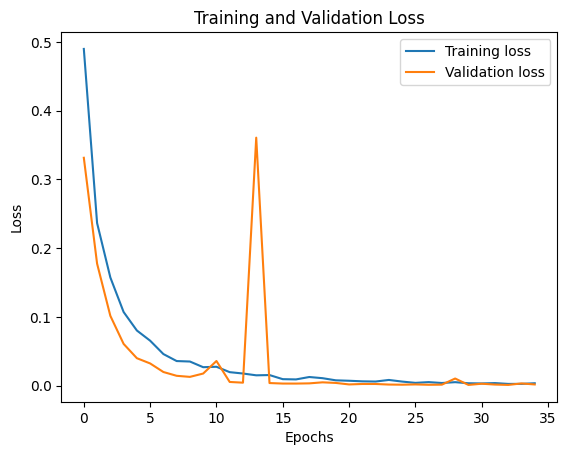

In [7]:
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=5, min_lr=0.000001, verbose=1, min_delta=1e-6)
opt = Adam(learning_rate=0.001) #Default 0.001
model.compile(optimizer=opt, loss='categorical_crossentropy')
early_stopping = EarlyStopping(
    monitor="val_loss",  
    patience=5,          
    restore_best_weights=True,  
    verbose=1            
)

model.fit([X_train, y_train, X_train], Y_train,
          epochs=60,
          batch_size=512,
          shuffle=True,
          callbacks=[h, rlr, early_stopping],
          validation_data=[[X_test, y_test, X_test], Y_test])


plt.plot(h.history['loss'], label='Training loss')
plt.plot(h.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


plt.show()

## 保存模型

In [79]:
model.save('Seq2Seq_model.keras') 

## 加载模型

In [14]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model('Seq2Seq_model.keras')

D:\machinelearning\envs\myenv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## 潜在空间生成分子

In [8]:
smiles_to_latent_model = Model([encoder_inputs, property_input], neck_outputs)


latent_input = Input(shape=(latent_dim,))
state_h_decoded_2 = decode_h(latent_input)
state_c_decoded_2 = decode_c(latent_input)
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])

inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))
inf_decoder_lstm = LSTM(lstm_dim,
                        return_sequences=True,
                        unroll=unroll,
                        stateful=True)
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)

In [9]:
for i in range(1, 3):  # i 是解码器相关的LSTM层（具体的层数需要根据你模型的具体结构来调整）
    sample_model.layers[i].set_weights(model.layers[i+7].get_weights())
sample_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (1, 1, 22)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (1, 1, 128)                 │          77,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (1, 1, 22)                  │           2,838 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,150 (313.09 KB)

 Trainable params: 80,150 (313.09 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
x_latent = smiles_to_latent_model.predict([X_test, y_test])

23817/23817 ━━━━━━━━━━━━━━━━━━━━ 169s 7ms/step


In [74]:
def latent_to_smiles(latent, property_value):
    states = latent_to_states_model.predict(latent, verbose=0)
    startidx = docs['<go>']
    samplevec = np.zeros((1, 1, len(docs)))  # 不要硬编码 22，使用 len(docs)
    samplevec[0, 0, startidx] = 1
    smiles = ""

    state_h, state_c = states

    for i in range(28):
        o = sample_model.predict(samplevec, verbose=0)
        sampleidx = np.argmax(o)
        samplechar = docs_swap[sampleidx]
        if samplechar != '<eos>':
            smiles = smiles + samplechar
            samplevec = np.zeros((1, 1, len(docs)))
            samplevec[0, 0, sampleidx] = 1
        else:
            break
    return smiles


In [75]:
property_value = np.array([0, -0.2, 20])

[11:37:24] Explicit valence for atom # 15 O, 3, is greater than permitted


COCOOCONOC1COCCCo1C


[11:37:26] Explicit valence for atom # 8 O, 4, is greater than permitted


COCCOCOCo1oc1COCC1oo1=CCON=O


[11:37:26] SMILES Parse Error: unclosed ring for input: 'COCCON1CF'


COCCON1CF


[11:37:28] SMILES Parse Error: ring closure 1 duplicates bond between atom 1 and atom 2 for input: 'oo1C1COC1=OCCO1CCO1=O=o3C1C4'


oo1C1COC1=OCCO1CCO1=O=o3C1C4


[11:37:29] SMILES Parse Error: unclosed ring for input: 'COCON1=O'


COCON1=O


[11:37:29] SMILES Parse Error: unclosed ring for input: 'COCCON1CF'


COCCON1CF


[11:37:30] SMILES Parse Error: unclosed ring for input: 'oo1CO1COC1COC'


oo1CO1COC1COC


[11:37:31] non-ring atom 0 marked aromatic


ocN1COC1COC


[11:37:32] SMILES Parse Error: unclosed ring for input: 'oOCCON1CCOC'


oOCCON1CCOC


[11:37:32] non-ring atom 0 marked aromatic


oO


[11:37:34] SMILES Parse Error: unclosed ring for input: 'COCONOC1COCo1oc1CCO=CO=COC=O'


COCONOC1COCo1oc1CCO=CO=COC=O


[11:37:36] SMILES Parse Error: ring closure 1 duplicates bond between atom 1 and atom 2 for input: 'oo1C1CON1CCCOC1OCCO1C'


oo1C1CON1CCCOC1OCCO1C


[11:37:38] SMILES Parse Error: ring closure 1 duplicates bond between atom 10 and atom 11 for input: 'oo1COC1OCOCOo1o1CCO1CCO1=OCC'


oo1COC1OCOCOo1o1CCO1CCO1=OCC


[11:37:39] SMILES Parse Error: unclosed ring for input: 'oOCCO1OCOCO'


oOCCO1OCOCO


[11:37:41] Explicit valence for atom # 7 O, 3, is greater than permitted


COCONOCO1OCCOCCo1


[11:37:43] SMILES Parse Error: unclosed ring for input: 'COCCOOC1oO1CCo1CCOCo1o1CCO=C'


COCCOOC1oO1CCo1CCOCo1o1CCO=C


[11:37:44] SMILES Parse Error: unclosed ring for input: 'CCOCOC1ONC'


CCOCOC1ONC


[11:37:46] SMILES Parse Error: unclosed ring for input: 'CCOCONOCC1OCCOo1CCo1OCo1o1CC'


CCOCONOCC1OCCOo1CCo1OCo1o1CC


[11:37:48] SMILES Parse Error: unclosed ring for input: 'CCOCOC1NOCCo1Ooc1OCCO=OC'


CCOCOC1NOCCo1Ooc1OCCO=OC


[11:37:50] SMILES Parse Error: ring closure 1 duplicates bond between atom 1 and atom 2 for input: 'oo1C1OCC1OC=OCC1OC=OC1'


oo1C1OCC1OC=OCC1OC=OC1


[11:37:51] SMILES Parse Error: ring closure 1 duplicates bond between atom 6 and atom 7 for input: 'CCOCONC1C1OCOCOC'


CCOCONC1C1OCOCOC
oOCCOCo1oco1O=COC=NCC


[11:37:52] Explicit valence for atom # 6 O, 4, is greater than permitted


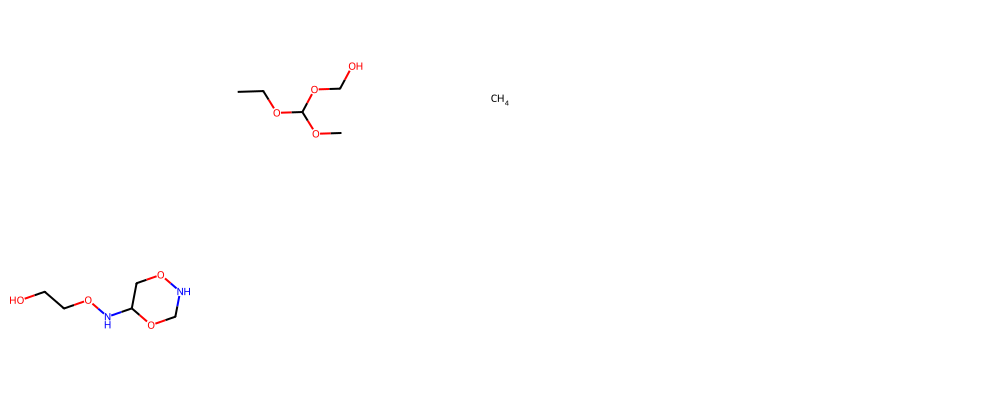

In [93]:
latent1 = x_latent[2:3]
latent0 = x_latent[8:9]
mols1 = []
ratios = np.linspace(0,1,30)
for r in ratios:
    rlatent = (1.0 - r) * latent0 + r * latent1
    smiles = latent_to_smiles(rlatent, property_value)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols1.append(mol)
    else:
        print(smiles)

Draw.MolsToGridImage(mols1, molsPerRow=5)